# Following up on midterm data
This week we wanted to focus on location based sentiment analysis using the newfound techniques we learned in class. We decided to focus closely on Mumbai and New Dehli, because our midterm data showed that those two locations had the highest number of sentiment scores.

Upon doing som additional research, we discovered that some of the trending reasons contributing to negative perspections on COVID vaccines in this area are:
1. The death of older folks who have been vaccinated
2. Rumors regarding allergic reactions towards the vaccine
3. Political issues regarding difficulty to get the Pfizer distributed throughout India.

Thus, in this lab, we had two main goals.
1. See if visualizing sentiment scores more constrained to these topics differs from that of our general visualization presented during the midterm. 
2. See how the two cities differ in terms of sentiment scores, see how specific tweets may differ/be consistent


In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import osmnx as ox
import matplotlib.pyplot as plt

# to get tweets
import tweepy as tw

# for sentiment analysis
from textblob import TextBlob
import re

# word clouds
from wordcloud import WordCloud, STOPWORDS

## importing libraries

First, we import the necessary libraries

In [2]:
# your twitter keys/secrets/tokens
consumer_key= 'EkosBgfWd7Aw3msXVQRASzvwV'
consumer_secret= 'GV4rCz0yaflrVuvjQhhFpFfbyDB4GQ8TGTDSQtSpAgcJlasrWl'
access_token= '721132181079195648-1kDWtftg4ICPPnwy5letbIsJqOHrIWq'
access_token_secret= 'RO7VLJutTwYDAKqWPwi84poJZR2VFl80UoFTy3JYBp33S'

In [3]:
# authenticate thyself with twitter
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

## authenticating ourselves
Next, we need to past the corrent information so we can access data from Twitter.

In [74]:
# search query
searchterm = 'vaccine'

# filter out retweets (optional of course)
q = searchterm + " -filter:retweets"

# how many?
max_tweets = 5000
 
# Creation of query method using parameters
tweets = tw.Cursor(api.search,
                   q=q, 
                   tweet_mode='extended').items(max_tweets)

In [61]:
# get a 5 colors from sequential color bar
stop_words = [searchterm] + list(STOPWORDS)+["COVID19","Covid","India","vaccine","death"]
sentiment_colors = ox.plot.get_colors(5,cmap='PiYG',return_hex=True)
def clean_tweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", tweet).split())

def make_dataframe(q, place, distance = '150km', count = 500):
    #
    # geocode the place to get coordinates
    #
    
    g = ox.geocoder.geocode(place)
    
    # concatenate the results
    geocode = '"'+str(g[0])+','+str(g[1])+','+distance+'"'
    
    #
    # grab the tweets
    #
    
    tweets = tw.Cursor(api.search,
                       q=q+' -filter:retweets', # no retweets
                       geocode=geocode, 
                       tweet_mode='extended').items(count)
    #
    # create a dataframe
    #
    
    json_data = [tweet._json for tweet in tweets]
    df = pd.json_normalize(json_data)

    # clean it up
    df = df[['created_at','full_text']]

    # clean the text
    df['clean_text'] = ''
    
    for i, row in df.iterrows():
        clean = clean_tweet(row.full_text)
        df.at[i,'clean_text'] = clean
        
    return df

def produce_visuals(df, wc = False, sa = False, tb = False):

    #
    # word cloud
    #
    if(wc):
        # put every tweet in a single variable
        all_text = ' '.join(df['clean_text'])

        # create the word cloud
        wordcloud = WordCloud(width=1200, 
                              height=800,
                              background_color="white",
                              stopwords=stop_words).generate(all_text)

        # Display the WordCloud                    
        plt.figure(figsize=(12,12))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

    #
    # sentiment analysis
    #
    if(sa):  
        df['polarity']=''

        # add polarity index to each tweet
        for i, row in df.iterrows():
            a = TextBlob(row.full_text)
            df.at[i,'polarity'] = a.polarity

        # create a list of our conditions
        conditions = [
            (df['polarity'] < -0.2), # very negative
            (df['polarity'] < 0) & (df['polarity'] >= -0.2),   # negative
            (df['polarity'] == 0),  # neutral
            (df['polarity'] > 0) & (df['polarity'] <= 0.2),    # positive
            (df['polarity'] > 0.2)  # very positive
            ]

        # create a list of the values we want to assign for each condition
        values = [
            'very negative', 
            'negative', 
            'neutral', 
            'positive',
            'very positive'
            ]

        # create a new column and use np.select to assign values to it using our lists as arguments
        df['sentiment'] = np.select(conditions, values)

        #
        # Sentiment bar chart
        #

        # bar chart
        fig = px.bar(df, 
                     x='sentiment',
                     width=600,
                     title='Sentiment analysis for "'+ q + '"',
                     color='sentiment',
                     category_orders = {'sentiment':['very negative','negative','neutral','positive','very positive']},
                     color_discrete_sequence=sentiment_colors, # use the colors selected in previous cell
                    )
        # fig.update_traces(textinfo='value')
        fig.update_traces(marker_line_width=0) # gets rid of horizontal white lines
        fig.show()

        #
        # histogram
        # 

        num_bins = 50
        plt.figure(figsize=(10,6))
        n, bins, patches = plt.hist(df.polarity, num_bins, facecolor='blue', alpha=0.5)
        plt.xlabel('Polarity')
        plt.ylabel('Count')
        plt.title('Histogram of polarity for "' + q + '"')

        plt.axvline(df.polarity.mean(), color='k', linestyle='dashed', linewidth=1)

        min_ylim, max_ylim = plt.ylim()
        plt.text(df.polarity.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(df.polarity.mean()))

        plt.show()

    #
    # Show top 10 and bottom 10 tweets
    #
    if(tb):
        top10 = df.sort_values('polarity').head(10)[['clean_text','polarity']]
        bottom10 = df.sort_values('polarity').tail(10)[['clean_text','polarity']]

        display('Top 10 negative tweets')
        display(top10)

        display('Top 10 positive tweets')
        display(bottom10)

## Setting search terms and setting up functions
Here, we take the framwork of the function created lastweek in class, but modify it in several ways.

First, we alter the stop words to contain the words "COVID19","Covid","India","vaccine","death".
Doing so constrains our search results to tweets more related to our hypothesis.

Next, we divide the find_tweets function into two functions make_dataframe(), and produce_visuals().

make_dataframe() takes in a variable q, a location place, a distance whose default value is 150km, and count whose default values is 500. It is responsible for creating a dataframe that we can later visualize

produce_visuals() takes in a dataframe df, and 3 bools whose default is false. Each bool corresponds to production of a word cloud, sentiment data, and top 10 and bottom 10 sentiment score tweets. We can selectively choose which visuals to choose by setting the boolean parameters to true or false. 

In [79]:
df_mumbai = make_dataframe(q='pfizer',place = 'mumbai')

In [81]:
df_newdehli = make_dataframe(q='pfizer',place = 'New Delhi')

We make two dataframes, one for each city, and use pfizer as a keyword. Hopefully, we can see some news about the political controversy regarding U.S involvement in vaccine distribution.

In [82]:
pd.set_option("display.max_colwidth", None)

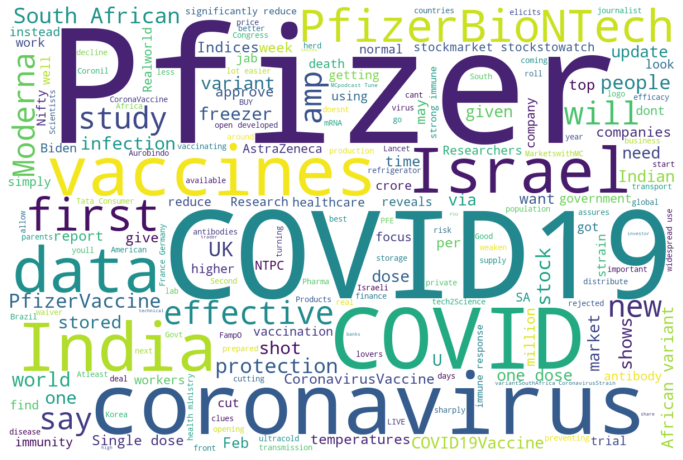

In [85]:
produce_visuals(df_mumbai, True)

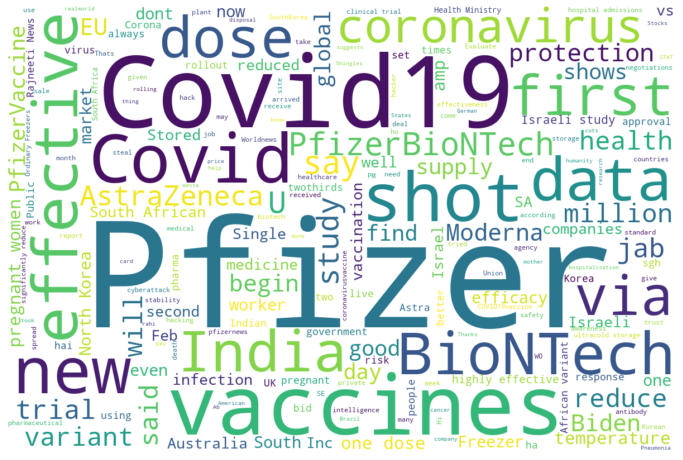

In [84]:
produce_visuals(df_newdehli, True)

The word clouds above suggest that the general sentiment towards the general tweets regarding pfizer are not particularly controversial. Lets create a sentiment analysis.

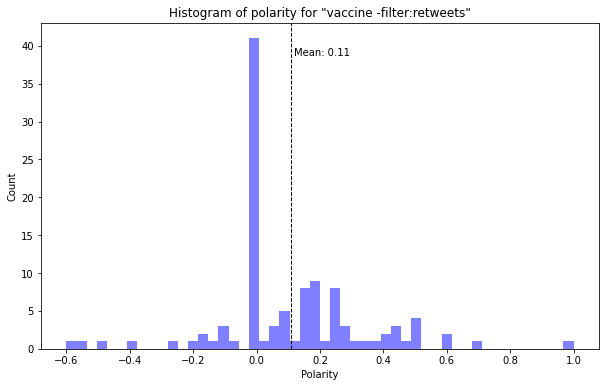

In [86]:
produce_visuals(df_mumbai, False, True)

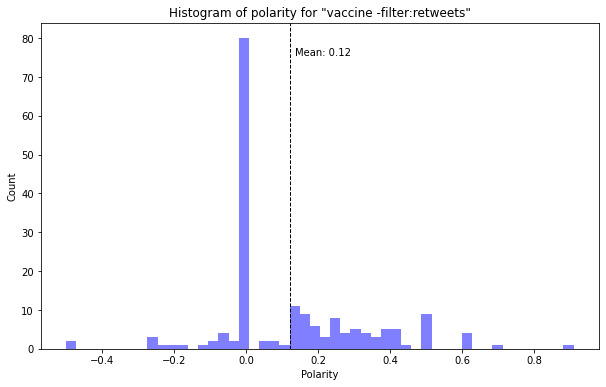

In [87]:
produce_visuals(df_newdehli, False, True)

suprisingly, we see here that there are few negative sentiment scores. We predict that this may be due to several of the following factors:
1. The dataset. This dataset is found directly through twitter, whereas our midterm dataset is curated by a datascientist before being uploaded onto kaggle. 
2. The method in whichh sentiment scores are generated can produce error. In this example, we generate sentiment scores using textblob, whereas we used the nltk library. We should use the nltk library in the future to check this bias.

In future labs, and in individual work, we hope to find a way to use the nltk library and our original dataset to produce similar graphs.

That being said, lets finally take a look at the top 10 highest and lowest sentiment scores.

In [88]:
produce_visuals(df_mumbai, False, False, True)

'Top 10 negative tweets'

,clean_text,polarity
48,Leaked report shows Pfizers vaccine is sharply cutting covid19 infections in Israel via,-0.6
35,This confused me so bad I was like tf is Pfizer doing,-0.55
34,unfortunately government of India hasnt given approval to pfizer vaccine yet,-0.5
93,IndiamartQIP base price at premiumLupinlaunched gnoxafil usd 3050mn opportunity Bharti airtel give exit to Warburg buy 20 stake in DTH arm minimnal dilutionCadila healthcarePfizer Sues Zydus to Block Generic Version of 22mg Xeljanz,-0.4
96,Singapore wary of closing border to migrant workers from India amp Indonesia SouthKorea says NorthKorea hacked Pfizer to steal COVID19 vaccine info Former Ecuador President Noboa diesA bitesized review of events from around the world,-0.25
56,I also support Coronil Vaccine of as compared to deadly mRNA vaccine of and others out to cull the population of the world,-0.2
3,People in France Germany and the UK are turning down the AstraZeneca vaccine because they want the Pfizer one,-0.155556
9,People in France Germany and the UK are turning down the AstraZeneca vaccine because they want the Pfizer one instead reports say,-0.155556
54,Countrywide data from Israel which leads the world in vaccinating its population reveals that the pfizer vaccine sharply cuts infections,-0.125
26,Progress Govt expert panel rejected Pfizers application seeking emergency nod for its Covid19 vaccine afterthe company insisted on waiver of clinical trial in India Getting a waiver was not possible it would opened floodgatesGovt cant set such a negative precedent for any company,-0.1


'Top 10 positive tweets'

,clean_text,polarity
63,Study in Israel shows Pfizer Covid19 vaccine 85 effective after first dose,0.425
106,It has to an extent Government is fighting to prove Covaxine is good instead of why vaccines are goodBut its also that you dont get a choice in vaccine If you ask people if to take the OxfordAZ vaccine the acceptance would be higher The Pfizer one probably even higher,0.475
5,Top stocks in focus Aurobindo Pharma NTPC Tata Consumer Pfizer SPARCnifty StockMarket StocksToWatch stock aurobindo NTPC TATACONSUM Pfizer,0.5
97,MCpodcast Tune in to CoronavirusEssential as we bring you all the top updates from today Coronavirus COVID19 Vaccine COVIDupdates,0.5
51,But doesnt Sputnik also needs subzero tempature like 7C Though better than Pfizers need of 80C but still unsuitable logistically for India,0.5
6,MarketswithMC Pfizer NTPC SBI Card and more Here are top stocks to watch out for tomorrow stocks StockMarket StocksTowatch,0.5
45,Pfizer vaccine 958 effective against COVID19 Israel Health Ministry,0.6
25,After vaccinating 425 million people Israel health ministry says Pfizer Covid19 jab 958 effective,0.6
55,Good news on the vaccine front Pfizer coronavirus vaccine no longer needs to be kept at supercold temperatures,0.7
62,Infy doing India proud,1


In [89]:
produce_visuals(df_newdehli, False, False, True)

'Top 10 negative tweets'

,clean_text,polarity
151,India ki vaccine hit hai pfizer foozer ki bhi fail ho rahi hai,-0.5
176,Nothing wrong and shocking in it Thats why Pfizer vaccine was not allowed in India It is always a practice to do clinical trials on local people before rolling out a medicine or vaccine to confirm its efficacy on that biological type,-0.5
54,sgh on odd days vs even days This lady said she would prefer Pfizer over any other Indian vaccine Now that Pfizer vaccine has turned out to be a disaster madam ke rang dekho Lip job nahi poori insaan hi fake ho tum,-0.263889
91,Pfizer Says Its Coronavirus Vaccine Can Be Stored In Ordinary Freezers NDTV,-0.25
95,Pfizer Says Its Coronavirus Vaccine Can Be Stored In Ordinary Freezers,-0.25
10,We need to seriously invoke Doha Declaration on Public Health and save humanity from exploitation of poor people If company is charging price why should govt pay the compensation Pfizer plays hardball in Covid19 vaccine negotiations STAT,-0.244444
34,AstraZenecas data hasnt cleared the threshold even in EU SA is returning it although Pfizer is also less effective in SA strain but AstraZeneca is worse All said and done AstraZeneca was always a doubtful starter,-0.191667
147,Single dumbest decision by our regulators We the citizens of Indians are the losers in this,-0.169643
22,As US registers 5 lac deaths due to Covid Pfizer pledges to trial of 3 rd booster dose to tackle the variants the trials will be commenced soon Covid19 PfizerVaccine,-0.125
51,sgh Tch Tch cast aspersions on Indian vaccine and say u r waiting for Pfizernow crying for the same Vax,-0.1


'Top 10 positive tweets'

,clean_text,polarity
146,After all brouhaha China and Russia vaccine turn out to be better than West Hopefully India vaccine will also be better than Pfizer AstraZeneca,0.5
153,Some of the prominent companies involved in developing therapies for Schizophrenia include es Tx and 33,0.5
61,Many said they dont trust Modi medicine not recognized Pfizer or whatever thats called is more trustable,0.5
128,Read more about it Pfizer covid vaccine COVID19 BioNtech,0.5
27,Scotland study shows Pfizer AstraZeneca Covid19 vaccines effective in preventing cases of severe infection,0.6
67,Covid19 jabs 958 effective after both Pfizer shots Israeli Health Ministry,0.6
104,Pfizer Shot Is Highly Effective After One Dose Study Shows,0.6
64,Covid19 jabs 958 effective after both Pfizer shots Israeli health ministry,0.6
168,More than 10 of Chileans have received the vaccine and Chile ranks 7th worldwide Diversification has been part of the formula it is set to receive vaccines from Pfizer AstraZeneca Sinovac JampJ and Covax Its robust history of negotiating trade deals has helped Good job,0.6875
100,Pfizer still very good vaccine despite study South Africa adviser,0.91


In [90]:
print(df_mumbai.loc[[26]])

                        created_at  \
26  Mon Feb 22 10:29:39 +0000 2021   

                                                                                                                                                                                                                                                                                                   full_text  \
26  @India_Progress Govt expert panel rejected Pfizer’s application seeking emergency nod for its Covid-19 vaccine after the company insisted on waiver of clinical trial in India. Getting a waiver was not possible, it would opened floodgates..Govt can't set such a negative precedent for any company.   

                                                                                                                                                                                                                                                                                  clean_text  \
26  Progress Govt expert p

In [91]:
print(df_newdehli.loc[[147]])

                         created_at  \
147  Thu Feb 18 05:19:56 +0000 2021   

                                                                                                                  full_text  \
147  Single dumbest decision by our regulators! We the citizens of Indians are the losers in this!\nhttps://t.co/Xrlyv7oMVT   

                                                                                      clean_text  \
147  Single dumbest decision by our regulators We the citizens of Indians are the losers in this   

     polarity sentiment  
147 -0.169643  negative  


We can see here that there are some tweets taking about the vaccine. It is interesting to note that when looking at these two negative sentiment score tweets, however, that one is defending the Indian government's decision to delay the Pfizer vaccine while another is bashing the decision. 

This goes to show that while a negative sentiment score indicates general dissatisfaction towards a certain topic (the government having to delay the process), it does not always show the same viewpoint. 

This can be interpreted as a negative, but I personally find it exciting in that we get to understand the several reasons as to why people are dissatisfied by the situation they are put in.

## Conclusion

Although there are potential biases in our sentiment score results, it is cool to see how accurately we are able to see people's reactions towards recent current events with location and keyword based data analysis. We hope to, in the future, try this out with out own dataset while also comparing tweets in relation to time. 

Additionally, a recent rumor in the U.S is that the vaccine causes infertility. Although a vast majority have disputed such claims, it is interesting to see if this has any influence on the sentiment scores of large cities like new york in comparison to the sentiment scores before such rumors began.